In [1]:
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2


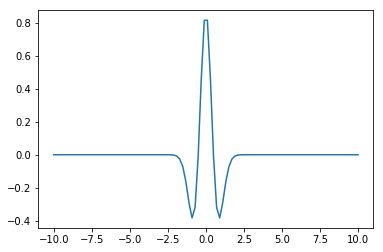

In [2]:
def mexican_hat(x, sigma=1.):
    a = 2./ ( np.sqrt(3*sigma) * np.power(np.pi,0.25 ) )
    b = (1. - (x/sigma)**2 )
    c = np.exp( - x**2/(2.*sigma**2))
    return a*b*c

def W_zero(x):
    a          = 1.0
    lambda_net = 4.0
    beta       = 3.0 / lambda_net**2
    gamma      = 1.05 * beta
    
    x_length_squared = x**2
    
    return a*np.exp(-gamma*x_length_squared) - np.exp(-beta*x_length_squared)

def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask





J = mexican_hat

x = np.linspace(-10.,10., num=100)
y = J(2*x)

plt.plot(x, y)


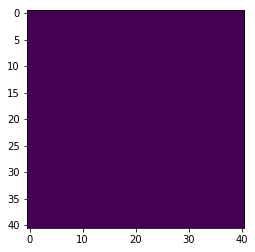

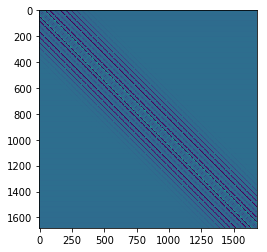

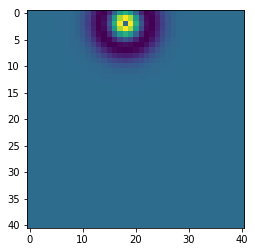

In [3]:
def normalize(x):
    x_   = x - np.amin(x)
    amax = np.amax(x_)

    if amax != 0.:
        x_ = x_/amax
    
    return x_



def create_W(J, D, s= 1.0, mask=None):

    if mask is None:
        mask = np.ones(D.shape[0]).astype(bool)
        
    W = np.zeros(D.shape)
    W = J(s*D) 
    W[~mask, :] = 0.
    W[:, ~mask] = 0.
    np.fill_diagonal(W, 0.0)
    
    for i in range(n):
        if mask[i]:
            W[i,:] -= np.mean(W[i,:])
    
    return W 



r  = 15.
n_ = 41

n = n_*n_


X = np.indices((n_,n_)).reshape((2,-1)).T/float(n_)
X = r*X


D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
            D[i,j] = np.linalg.norm( X[i] - X[j])

        

J = mexican_hat


center = [n_//2 , n_//2 ]
cmask  = createCircularMask(n_, n_, center=center, radius=n_//2 )

cmask = (np.ones((n_,n_)) == 1)
W = create_W(J, D, s=1.,mask= cmask.reshape(-1))

plt.imshow(cmask)
plt.show()
plt.imshow(W)
plt.show()
plt.imshow(W[100].reshape((n_,n_)) )
plt.show()



0
10
20
30
40
50
60
70
80
90
(79, 79)


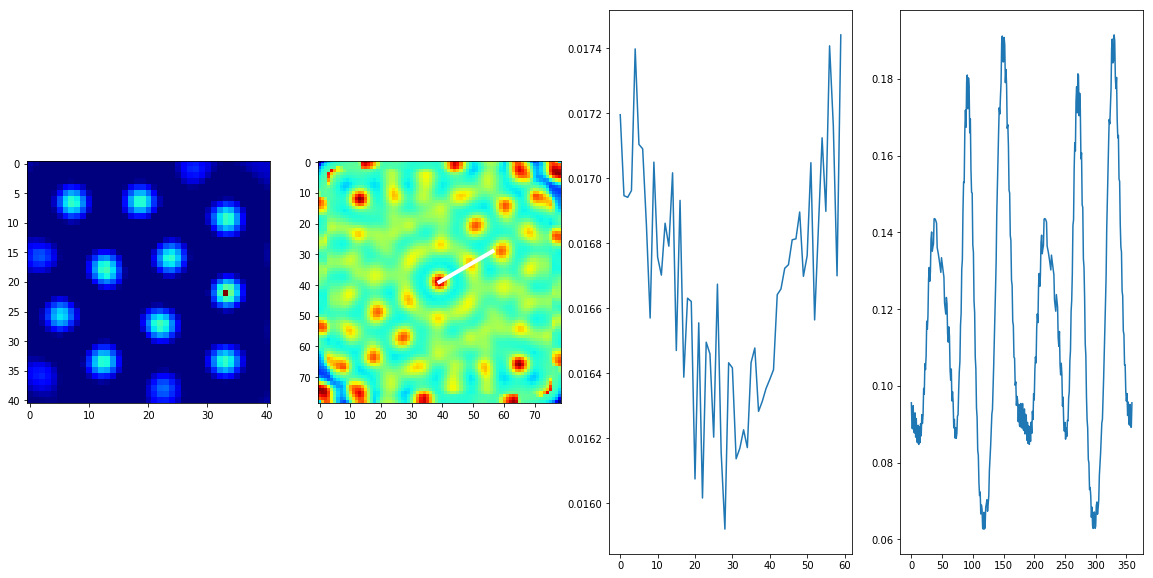

In [584]:
from htmresearch.support.gridcells.utils import cross_correlate
from scipy import ndimage
import numpy.fft as fft
from scipy.special import expit




def evolve(s, W, b, time=500):
    dt   = 0.01
    tau  = 1.0
    S    = np.zeros((time, W.shape[1]))
    S[0] = s[:] 
    for t in range(1, time):
        noise = np.random.sample(n)*0.001

        ds  = dt*( np.maximum(  np.dot(W, S[t-1] + noise) + b, 0.) - S[t-1])
        S[t,:]  = S[t-1,:] + tau*ds
        S[t,:] /= np.sum(S[t,:]**2)
        
    return S


def crystallize(W,b,s):

    T = 500
    S  = evolve(s, W, b, time=T)
    S_ = evolve(S[-1], W, b=np.zeros(n), time=T)
    

    activity = S[-1].reshape((n_,n_))
    auto = cross_correlate(activity,activity)

    return activity, auto, np.concatenate([S,S_], axis=0)






def compute_grid_score(auto):
    num = 360
    score = np.zeros(num)
    or_score = np.zeros(num)

    


    h, w = auto.shape
    r = 15
    mask  = createCircularMask(w, h, center=[h//2, w//2], radius=r)
    


    for i,d in enumerate(np.linspace( 0., 360., num=num)):
        auto_ = ndimage.rotate(auto, d)

        h_, w_ = auto_.shape
        or_score[i] += np.mean( auto_[h_//2, (w_//2)-r:(w_//2)+r ])
        mask_  = createCircularMask(w_, h_, center=[h_//2, w_//2], radius=r)
        score[i] =  np.mean( normalize(auto[mask]) * normalize(auto_[mask_]) )


    f_score = np.zeros(60)
    for i in range(3):
        i_  = i+1
        f_score += score[i*60:i_*60]
    
    f_score /= np.sum(f_score)
    return f_score, or_score



def is_griddy(score):
    diff = np.max(score) - np.min(score) 
    return np.amax(score) > .02 and np.amin(score) < 0.0135



num_samples = 100
angles = []
imgs   = []
autos  = []

t = 0
while t <num_samples:
    b = np.zeros(n)
    i = np.random.choice(n)
    b[i] = 1.
    s = np.zeros(n)
    img, auto, S = crystallize(W, b, s)
    
    auto[np.isnan(auto)] = 0.

    if t%10 ==0:
        print t
    

    score, or_score = compute_grid_score(auto)
    

#     if is_griddy(score):
    if True:
        deg = np.argmax(or_score)
        angles.append(deg)
        imgs.append(img)
        autos.append(auto)
        t += 1
    else:
        print "not griddy"

        
summary = ""

fig, ax = plt.subplots(1, 4, figsize=(20,10));
ax[0].imshow(img, cmap="jet")


deg = angles[-1]
x, y = n_-2, n_-2
print auto.shape
end_x, end_y = [
    20*np.cos(deg/360.*np.pi*2.),
    20*np.sin(deg/360.*np.pi*2.)]

ax[1].plot([x, x + end_x], [y, y + end_y], c="white", linewidth=4.)

ax[1].imshow(auto, cmap="jet")
ax[2].plot(score)
ax[3].plot(or_score)
plt.show()



100


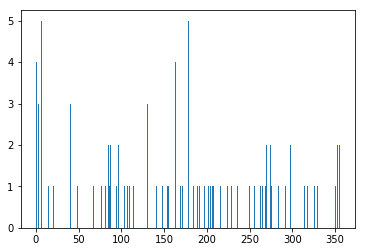

In [585]:
print len(angles)
plt.hist(np.array(angles),bins=360);

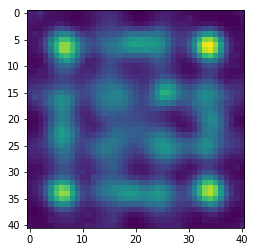

In [587]:

plt.imshow(np.mean( np.array(imgs[:]),axis=0))
# plt.imshow(imgs[8])

(79, 79)


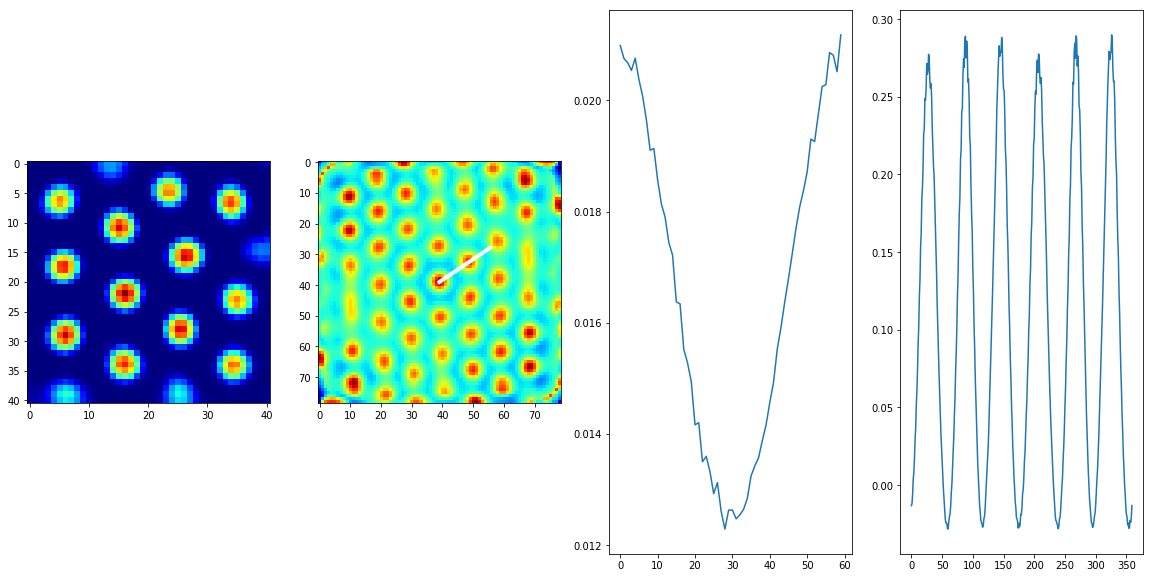

In [547]:
fig, ax = plt.subplots(1, 4, figsize=(20,10));
ax[0].imshow(img, cmap="jet")


deg = angles[-1]
x, y = n_-2, n_-2
print auto.shape
end_x, end_y = [
    20*np.cos(deg/360.*np.pi*2.),
    20*np.sin(deg/360.*np.pi*2.)]

ax[1].plot([x, x + end_x], [y, y + end_y], c="white", linewidth=4.)

ax[1].imshow(auto, cmap="jet")
ax[2].plot(score)
ax[3].plot(or_score)
plt.show()


In [985]:
from matplotlib import animation, rc
from IPython.display import HTML


fig, ax = plt.subplots(1, 2, figsize=(15, 10));



# animation function. This is called sequentially
def animate(i):
    ax[0].imshow(S[i].reshape((n_,n_)), animated=True)
    return []


# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=500, interval=20, blit=False)

print "done animating..."
plt.close(anim._fig)


done animating...


KeyboardInterrupt: 

done


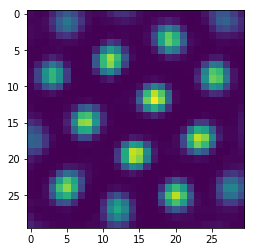

In [994]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
fig = plt.figure()


ims =[]

for i in range(len(S)):
    im = plt.imshow(S[i].reshape((n_,n_)), animated=True)
    ims.append([im])

    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')
print "done"
# plt.show()